### Set the anatomical Mask



In [1]:
# load packages
import os  
import pandas as pd
import glob
import nibabel as nib
import numpy as np
import json

from nilearn import image, plotting, masking
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker

from bids import BIDSLayout, BIDSValidator

/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/miniconda3/envs/fmri01/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

In [2]:
# set paths for directories

user_path = os.path.expanduser('~')
home_path = os.path.join('/Volumes','nova')
project_path = os.path.join(home_path,'projects','2019_Gamble_fMRI')
data_path = os.path.join(project_path,'data')
fmriprep_path = os.path.join(project_path,'data','derivatives','fmriprep')
betaseries_path = os.path.join(project_path,'data','derivatives','nibetaseries_orig')
note_path = os.path.join(user_path,'Desktop','GamblefMRI','runs','searchlight_lmer13')
mask_path = os.path.join(note_path,'roi_mask_thre')

if not os.path.exists(mask_path):
    os.mkdir(mask_path) 

In [3]:
# manipulating atlas
atlas_path = os.path.join(user_path,'Desktop','GamblefMRI','atlas','bn_atlas')
if not os.path.exists(atlas_path):
    atlas_path = os.path.join(project_path,'atlas','bn_atlas') 
    
atlas_filename = os.path.join(atlas_path,'BN_Atlas_246_2mm.nii.gz')
label_filename = os.path.join(atlas_path,'BN_Atlas_246_LUT.txt')

# read look-up-table and images
master_label = pd.read_csv(label_filename, sep=' ', names = ['index','region','dx','dy','dz','dummy'])
master_atlas = image.load_img(atlas_filename)

/Users/nova/.local/lib/python3.7/site-packages/nilearn/plotting/img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


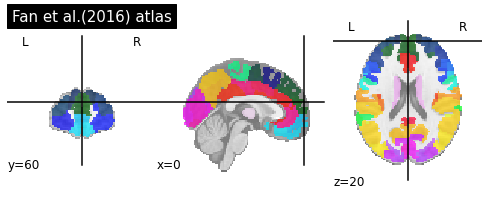

In [4]:
wb_mask_file = os.path.join('task-gamble_desc-group_mask.nii.gz')
mask_image = image.load_img(wb_mask_file) # this file for affine information

display = plotting.plot_roi(master_atlas, title='Fan et al.(2016) atlas', cut_coords=(0,60,20))

In [5]:
target_list = ['image_condition:gamble_choice',
               'image_condition:prev_image',
               'image_condition:prev_image:prev_choice',
               'image_condition:gamble_choice:prev_image:prev_choice']


brain_roi = image.math_img('img*0', img = mask_image)

for idx_target, this_target in enumerate(target_list):
    for idx_dir, this_dir in enumerate(['pos','neg']):

        filename = os.path.join(note_path,'mask_thre',
                                'tfce975_dir-%s_desc-%s_mask.nii.gz' %(this_dir,this_target))
        brain_roi = image.math_img('img1 + img2', img1 = brain_roi, img2 = filename)
        
brain_roi = image.math_img('img > 0', img = brain_roi)
nib.save(brain_roi, os.path.join(mask_path,'sub-all_desc-union_mask.nii.gz'))

In [6]:
brain_roi_atlas_affine = image.math_img('img > 0.5', img = image.resample_to_img(brain_roi,master_atlas))
nib.save(brain_roi_atlas_affine, os.path.join(note_path,'roi_mask_thre','sub-all_space-atlas_desc-union_mask.nii.gz'))

/Users/nova/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/Users/nova/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


In [7]:
# find union with each parcels of atlas

for idx_label, this_label in enumerate(master_label['region']):
    this_roi = image.math_img('np.logical_and(img1,img2)',
                              img1 = brain_roi_atlas_affine, 
                              img2 = image.math_img(f'img == {idx_label}',img = master_atlas))
    
    roi_indices, roi_counts = np.unique(this_roi.get_fdata(), 
                                    return_counts = True)
    roi_indices0, roi_counts0 = np.unique(image.math_img(f'img == {idx_label}',img = master_atlas).get_fdata(),
                                          return_counts = True)
    
    if idx_label > 0:
        if len(roi_indices) > 1:
            if (roi_counts[1] > 10):
                print(f'{idx_label}-{this_label}: {roi_counts[1]} / {roi_counts0[1]}')

                # display = plotting.plot_roi(image.math_img(f'img == {idx_label}',img = master_atlas))
                # display.add_overlay(brain_roi, cmap = plotting.cm.alpha_cmap('white'))

2-A8m_R: 123 / 883
3-A8dl_L: 28 / 907
5-A9l_L: 73 / 776
6-A9l_R: 38 / 914
11-A9m_L: 34 / 689
12-A9m_R: 104 / 892
13-A10m_L: 47 / 1075
14-A10m_R: 234 / 924
15-A9/46d_L: 13 / 1089
20-A46_R: 163 / 1019
28-A10l_R: 154 / 1031
41-A14m_L: 73 / 518
42-A14m_R: 63 / 630
46-A11l_R: 28 / 1210
47-A11m_L: 16 / 637
48-A11m_R: 50 / 732
50-A13_R: 19 / 800
180-A32p_R: 41 / 373
187-A32sg_L: 31 / 636
219-vCa_L: 207 / 463
220-vCa_R: 252 / 334
223-NAC_L: 79 / 321
224-NAC_R: 158 / 395
226-vmPu_R: 84 / 246
228-dCa_R: 45 / 674


In [8]:
# set ROIs within each parcel 
roi_dict_1 = {'c1_R':['vCa_R','NAC_R','vmPu_R'], # ventral striatum
              'c2_L':['vCa_L'], # ventral striatum
              'c3_L':['A8dl_L','A9l_L'], # dorsolateral
              'c4_M':['A14m_L','A11m_R','A14m_R'], # ventromedial
              'c5_R':['A10m_R']} # frontopolar # too small once white matters are removed

roi_dict_2 = {'c1_R':['A10l_R','A11l_R'], # ventrolateral
              'c2_M':['A8m_R','A8m_L'], # medialfrontal 
              'c3_R':['A46_R'], # lateral 
              'c4_M':['A10m_L','A9m_L','A10m_R','A9m_R','A32p_R','A32sg_L']} # frontopolar + cingulate

roi_dict_3 = {'c1_M':['A10m_L','A10m_R']} # mediofrontal


In [9]:
roi_dict = [roi_dict_1, roi_dict_2, roi_dict_3]

roi_target_list = ['image_condition:gamble_choice',
               'image_condition:prev_image',
               'image_condition:gamble_choice:prev_image:prev_choice']

/Users/nova/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/Users/nova/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


{'c1_R': ['vCa_R', 'NAC_R', 'vmPu_R'], 'c2_L': ['vCa_L'], 'c3_L': ['A8dl_L', 'A9l_L'], 'c4_M': ['A14m_L', 'A11m_R', 'A14m_R'], 'c5_R': ['A10m_R']}


/Users/nova/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/Users/nova/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/Users/nova/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/Users/nova/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binar

{'c1_R': ['A10l_R', 'A11l_R'], 'c2_M': ['A8m_R', 'A8m_L'], 'c3_R': ['A46_R'], 'c4_M': ['A10m_L', 'A9m_L', 'A10m_R', 'A9m_R', 'A32p_R', 'A32sg_L']}


/Users/nova/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/Users/nova/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/Users/nova/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/Users/nova/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binar

{'c1_M': ['A10m_L', 'A10m_R']}


/Users/nova/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/Users/nova/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


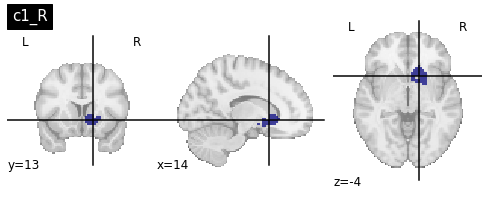

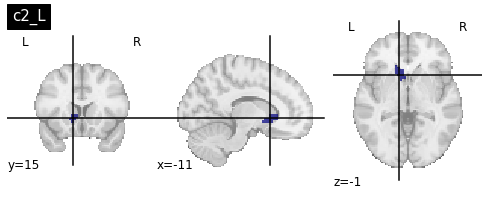

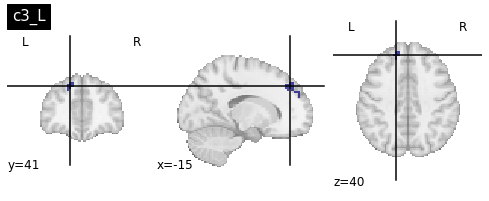

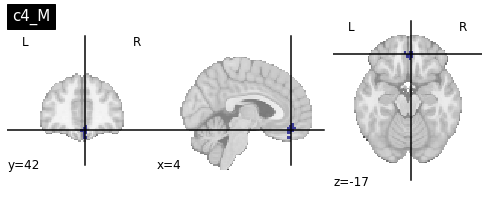

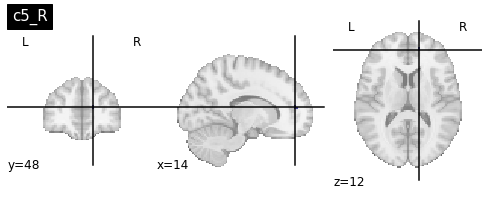

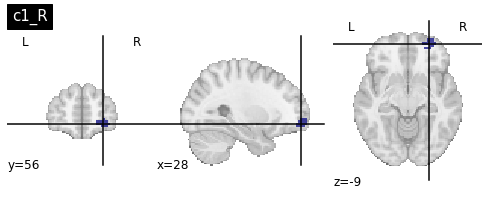

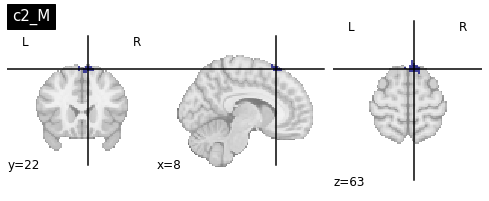

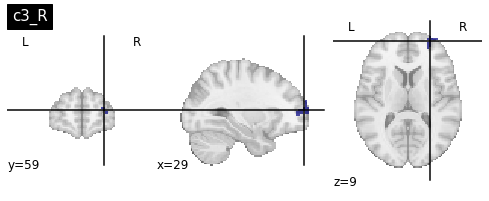

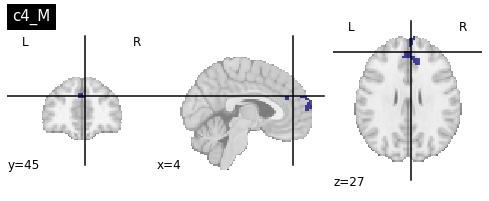

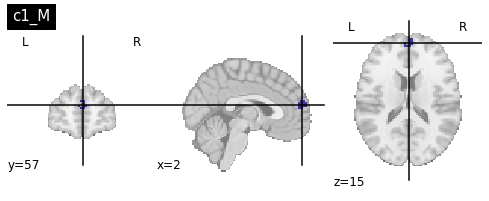

In [10]:


for idx_target, this_target in enumerate(roi_target_list):
    
    brain_roi = image.math_img('img*0', img = mask_image)
    filename = os.path.join(note_path,'mask_thre',
                            'tfce975_dir-%s_desc-%s_mask.nii.gz' %('pos',this_target))
    
    brain_roi = image.math_img('img1 + img2',img1 = brain_roi, img2 = filename)
    brain_roi = image.math_img('img > 0', img = brain_roi)
    brain_roi_atlas_affine = image.math_img('img > 0.5', img = image.resample_to_img(brain_roi,master_atlas))
    
    this_roi_dict = roi_dict[idx_target]
    
    print(this_roi_dict)
    
    for this_roi in this_roi_dict:
        region_roi = image.math_img('img*0', img = brain_roi_atlas_affine)
        
        for this_parcel in this_roi_dict[this_roi]:
            index = master_label['index'].loc[master_label['region'] == this_parcel].index.values[0]
            
            tmp = image.math_img(f'np.logical_and(img0, img1 == {index})',
                             img0 = brain_roi_atlas_affine, 
                             img1 = master_atlas)
            
            region_roi = image.math_img('img1 + img2', 
                                   img1 = region_roi,
                                   img2 = tmp)
        
        region_roi = image.math_img('img > 0', img = region_roi)
        
        
        
        region_roi_mask_affine = image.math_img('img > 0.5', img = image.resample_to_img(region_roi,mask_image))
        plotting.plot_roi(region_roi_mask_affine,
                          title = this_roi)
        nib.save(region_roi_mask_affine,
                 os.path.join(note_path,'roi_mask_thre',
                              'mask-%s-%s.nii.gz' %(this_target, this_roi)))
        

### Count the voxels within each ROI

In [22]:
for idx_target, this_target in enumerate(roi_target_list):   
    this_roi_dict = roi_dict[idx_target]
    for this_roi in this_roi_dict:
        filename = os.path.join(note_path,'roi_mask_thre','mask-%s-%s.nii.gz' %(this_target, this_roi))
        print(filename)

        nii = nib.load(filename)
        mm = nii.header['pixdim'][1] * nii.header['pixdim'][2] * nii.header['pixdim'][3]
        mm = abs(mm)
        img_np = nii.get_fdata()
        vox_count = (img_np == 1).sum()
        print('{} mm^3 for region {}'.format(vox_count * mm, 1))
            

/Users/nova/Desktop/GamblefMRI/runs/searchlight_lmer13/roi_mask_thre/mask-image_condition:gamble_choice-c1_R.nii.gz
4077.0 mm^3 for region 1
/Users/nova/Desktop/GamblefMRI/runs/searchlight_lmer13/roi_mask_thre/mask-image_condition:gamble_choice-c2_L.nii.gz
1620.0 mm^3 for region 1
/Users/nova/Desktop/GamblefMRI/runs/searchlight_lmer13/roi_mask_thre/mask-image_condition:gamble_choice-c3_L.nii.gz
918.0 mm^3 for region 1
/Users/nova/Desktop/GamblefMRI/runs/searchlight_lmer13/roi_mask_thre/mask-image_condition:gamble_choice-c4_M.nii.gz
1512.0 mm^3 for region 1
/Users/nova/Desktop/GamblefMRI/runs/searchlight_lmer13/roi_mask_thre/mask-image_condition:gamble_choice-c5_R.nii.gz
81.0 mm^3 for region 1
/Users/nova/Desktop/GamblefMRI/runs/searchlight_lmer13/roi_mask_thre/mask-image_condition:prev_image-c1_R.nii.gz
1620.0 mm^3 for region 1
/Users/nova/Desktop/GamblefMRI/runs/searchlight_lmer13/roi_mask_thre/mask-image_condition:prev_image-c2_M.nii.gz
1107.0 mm^3 for region 1
/Users/nova/Desktop/Ga

In [24]:
roi_dict

[{'c1_R': ['vCa_R', 'NAC_R', 'vmPu_R'],
  'c2_L': ['vCa_L'],
  'c3_L': ['A8dl_L', 'A9l_L'],
  'c4_M': ['A14m_L', 'A11m_R', 'A14m_R'],
  'c5_R': ['A10m_R']},
 {'c1_R': ['A10l_R', 'A11l_R'],
  'c2_M': ['A8m_R', 'A8m_L'],
  'c3_R': ['A46_R'],
  'c4_M': ['A10m_L', 'A9m_L', 'A10m_R', 'A9m_R', 'A32p_R', 'A32sg_L']},
 {'c1_M': ['A10m_L', 'A10m_R']}]

### Draw Clusters 

c1_R
c2_L
c3_L
c4_M
c1_R
c2_M
c3_R
c4_M
c1_M


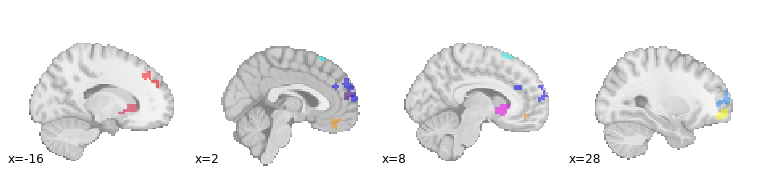

In [26]:
# display = plotting.plot_anat(display_mode = 'x',
#                              cut_coords = [-15,-11,2,4,8,14,28,29])

display = plotting.plot_anat(display_mode = 'x',
                             cut_coords = [-16,2,8,28])

cluster_color = ['magenta','crimson','red','darkorange','yellow','cyan','dodgerblue','blue','indigo','lime']

idx = 0

for idx_target, this_target in enumerate(roi_target_list):   
    this_roi_dict = roi_dict[idx_target]
    for this_roi in this_roi_dict:
        if this_roi != 'c5_R':
            print(this_roi)
            filename = os.path.join(note_path,'roi_mask_thre','mask-%s-%s.nii.gz' %(this_target, this_roi))
            display.add_overlay(filename, cmap = plotting.cm.alpha_cmap(cluster_color[idx]))
            idx = idx + 1

# display.savefig(os.path.join(note_path,'figures','brain-x-cut.svg'))

c1_R
c2_L
c3_L
c4_M
c1_R
c2_M
c3_R
c4_M
c1_M


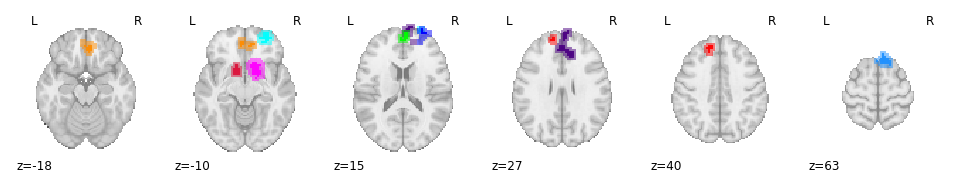

In [49]:
# display = plotting.plot_anat(display_mode = 'z',
#                              cut_coords = [-17,-9,-4,-1,9,12,15,27,40,63])

display = plotting.plot_anat(display_mode = 'z',
                             cut_coords = [-18,-10,15,27,40,63])

cluster_color = ['magenta','crimson','red','darkorange','cyan','dodgerblue','blue','indigo','lime']

idx = 0

for idx_target, this_target in enumerate(roi_target_list):   
    this_roi_dict = roi_dict[idx_target]
    for this_roi in this_roi_dict:
        if this_roi != 'c5_R':
            print(this_roi)
            filename = os.path.join(note_path,'roi_mask_thre','mask-%s-%s.nii.gz' %(this_target, this_roi))
            display.add_overlay(image.smooth_img(filename,2.5),
                                    cmap = plotting.cm.alpha_cmap(cluster_color[idx]))
            idx = idx + 1
        

display.savefig(os.path.join(note_path,'figures','brain-z-cut.svg'))

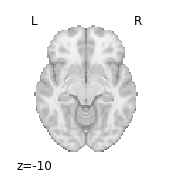

In [52]:
display = plotting.plot_anat(display_mode = 'z',
                             cut_coords = [-10])

display.savefig(os.path.join(note_path,'figures','anat-z-cut.svg'))